In [98]:
# Clear the workspace
rm(list = ls())

# Load libraries
library(tidyverse)
library(stringr)
library(lubridate)
library(engsoccerdata)

In [99]:
# Store EPL data
epl <- as_tibble(engsoccerdata::england)

# Take a look at the first 10 rows
epl[1:5,]

Date,Season,home,visitor,FT,hgoal,vgoal,division,tier,totgoal,goaldif,result
1888-12-15,1888,Accrington F.C.,Aston Villa,1-1,1,1,1,1,2,0,D
1889-01-19,1888,Accrington F.C.,Blackburn Rovers,0-2,0,2,1,1,2,-2,A
1889-03-23,1888,Accrington F.C.,Bolton Wanderers,2-3,2,3,1,1,5,-1,A
1888-12-01,1888,Accrington F.C.,Burnley,5-1,5,1,1,1,6,4,H
1888-10-13,1888,Accrington F.C.,Derby County,6-2,6,2,1,1,8,4,H


Before doing any more wrangling, let's create ID variables for each piece of information that may come in useful later. We'll create two ID sets: for matches and teams.

In [100]:
# Create a team ID
epl1 <- epl %>%
       unique(.) %>%
       mutate(
             
           match_id = seq(1:nrow(.))
        )

# Take a look
epl1[1:5,]

Date,Season,home,visitor,FT,hgoal,vgoal,division,tier,totgoal,goaldif,result,match_id
1888-12-15,1888,Accrington F.C.,Aston Villa,1-1,1,1,1,1,2,0,D,1
1889-01-19,1888,Accrington F.C.,Blackburn Rovers,0-2,0,2,1,1,2,-2,A,2
1889-03-23,1888,Accrington F.C.,Bolton Wanderers,2-3,2,3,1,1,5,-1,A,3
1888-12-01,1888,Accrington F.C.,Burnley,5-1,5,1,1,1,6,4,H,4
1888-10-13,1888,Accrington F.C.,Derby County,6-2,6,2,1,1,8,4,H,5


In [101]:
# Create a team list
team_list <- epl1 %>%
             select(home) %>%
             unique(.) %>%
             mutate(
                
                team_id = seq_along(home),
                 
             )

# Take a look
team_list[1:5,]

home,team_id
Accrington F.C.,1
Aston Villa,2
Blackburn Rovers,3
Bolton Wanderers,4
Burnley,5


In [102]:
# Join them up
epl <- inner_join(epl1, team_list)

# Take a look
epl[1:5,]

Joining, by = "home"


Date,Season,home,visitor,FT,hgoal,vgoal,division,tier,totgoal,goaldif,result,match_id,team_id
1888-12-15,1888,Accrington F.C.,Aston Villa,1-1,1,1,1,1,2,0,D,1,1
1889-01-19,1888,Accrington F.C.,Blackburn Rovers,0-2,0,2,1,1,2,-2,A,2,1
1889-03-23,1888,Accrington F.C.,Bolton Wanderers,2-3,2,3,1,1,5,-1,A,3,1
1888-12-01,1888,Accrington F.C.,Burnley,5-1,5,1,1,1,6,4,H,4,1
1888-10-13,1888,Accrington F.C.,Derby County,6-2,6,2,1,1,8,4,H,5,1


In [103]:
# Join the visiting team data
epl <- team_list %>% 
       rename(., visitor = home) %>%
       inner_join(epl, ., by = 'visitor') %>% 
       rename(., home_id = 'team_id.x', away_id = 'team_id.y')

# Take a look
epl[1:5,]

Date,Season,home,visitor,FT,hgoal,vgoal,division,tier,totgoal,goaldif,result,match_id,home_id,away_id
1888-12-15,1888,Accrington F.C.,Aston Villa,1-1,1,1,1,1,2,0,D,1,1,2
1889-01-19,1888,Accrington F.C.,Blackburn Rovers,0-2,0,2,1,1,2,-2,A,2,1,3
1889-03-23,1888,Accrington F.C.,Bolton Wanderers,2-3,2,3,1,1,5,-1,A,3,1,4
1888-12-01,1888,Accrington F.C.,Burnley,5-1,5,1,1,1,6,4,H,4,1,5
1888-10-13,1888,Accrington F.C.,Derby County,6-2,6,2,1,1,8,4,H,5,1,6


In [207]:
# Input: Team ID 
# Match level data-set for that team with recovery time attached

calculate_recovery_time <- function(team_id, home = 1){
  'Input: Team ID
   Output: Data-set of team games with recovery time in days'   
  
  # Depending on whether we want home or away
  team_data <- epl %>% 
              {if(home == 1) 
              filter(., home_id == team_id) 
              else 
              filter(., away_id == team_id)} %>%    
              arrange(Date, Season) %>%
              group_by(Season) %>%
              mutate(
                
                Date = ymd(Date),
                recov_days = as.numeric(Date - lag(Date))
           
               ) %>%  
              ungroup(.)
         
    # Return statement
    return(team_data)
}

In [208]:
# Now calculate recovery time for home games each team and concatenate
home_data <- do.call(rbind, map(team_list$team_id, calculate_recovery_time, home = 1)) 

In [209]:
# ...and now for away games
away_data <- do.call(rbind, map(team_list$team_id, calculate_recovery_time, home = 2)) 

In [210]:
# Sanity checks
nrow(home_data)
nrow(away_data)
colnames(recovery_data)

# Everything should check out: 192004 rows in each set

[1] 192004

[1] 192004

[1] "Date"       "Season"     "home"       "visitor"    "FT"        
 [6] "hgoal"      "vgoal"      "division"   "tier"       "totgoal"   
[11] "goaldif"    "result"     "match_id"   "home_id"    "away_id"   
[16] "recov_days"

In [215]:
# Now merge these two data-sets to get recovery times by match for both home and away
full_recov_data <- away_data %>% 
                   select(team_id, match_id, recov_days) %>% 
                   inner_join(home_data, ., by = 'match_id') %>%
                   select(-Date.y) %>%
                   rename(home_recov_days = recov_days.x, away_recov_days = recov_days.y)

In [224]:
# Create a variable which measures the difference in recovery times
full_recov_data <- full_recov_data %>%
                   mutate(
                   
                       recov_day_diff = home_recov_days - away_recov_days,
                   
                   )

In [230]:
# This data-set contains tier 1 games
tier_1_games <- full_recov_data %>%
                filter(tier == 1)

In [231]:
# Calculate home advantage using simple average
# Only for tier 1 (win + draw %)
home_advantage <- tier_1_games %>%  
                  filter(result == "H"|result == "D") %>% 
                  nrow(.)/nrow(tier_1_games)

# This is the home advantage
home_advantage

[1] 0.7578161

In [232]:
# Calculate average goal difference scored in home wins
home_win_dif <- tier_1_games %>% 
                filter(result == "H") %>%
                select(goaldif)

# Display
sum(home_win_dif)/nrow(home_win_dif)

[1] 2.058262

[1] "Date.x"          "Season"          "home"            "visitor"        
 [5] "FT"              "hgoal"           "vgoal"           "division"       
 [9] "tier"            "totgoal"         "goaldif"         "result"         
[13] "match_id"        "home_id"         "away_id"         "home_recov_days"
[17] "away_recov_days" "recov_day_diff"

In [261]:
# Check the column names
colnames(tier_1_games)

[1] "Date.x"          "Season"          "home"            "visitor"        
 [5] "FT"              "hgoal"           "vgoal"           "division"       
 [9] "tier"            "totgoal"         "goaldif"         "result"         
[13] "match_id"        "home_id"         "away_id"         "home_recov_days"
[17] "away_recov_days" "recov_day_diff"

Warning message:
“Removed 485 rows containing non-finite values (stat_count).”

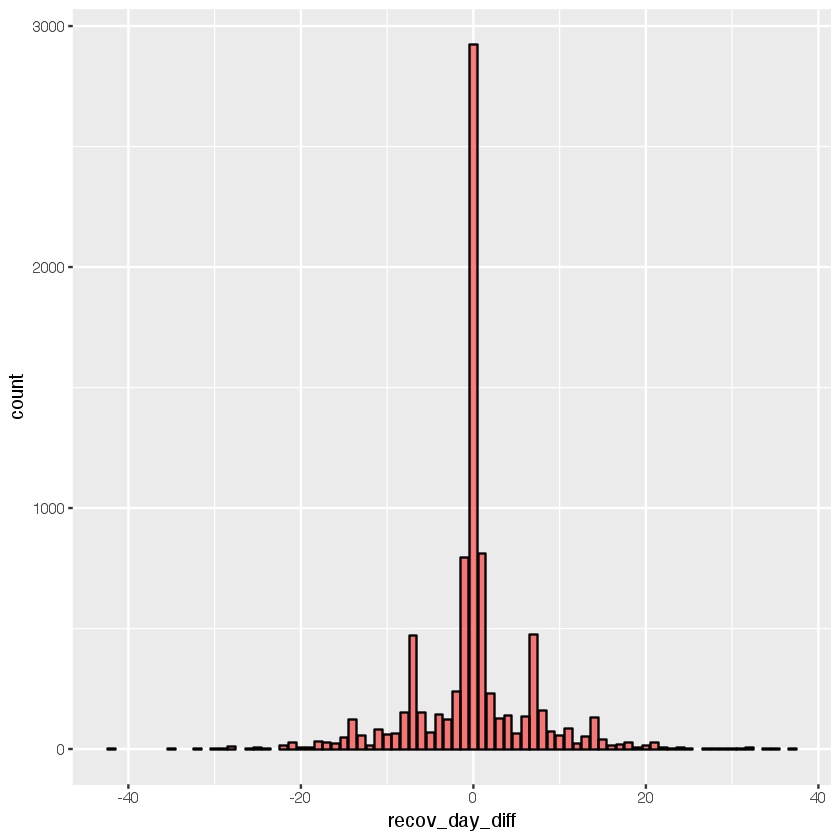

In [264]:
# Plot histogram of recovery day difference
ggplot(tier_1_games %>% 
       filter(Season > 1992)) + 
       geom_bar(aes(x = recov_day_diff), 
                    alpha = 0.5, 
                    fill = 'red', 
                    color = 'black')

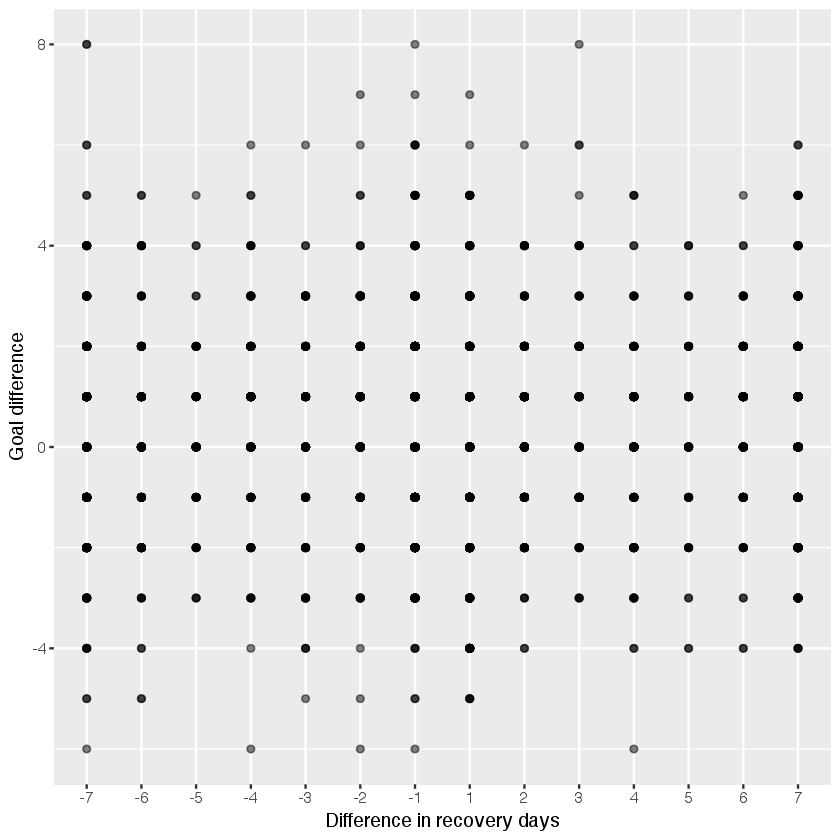

In [265]:
# Now plot recovery time 
ggplot(data = tier_1_games %>% 
       filter(Season > 1992) %>%
       filter(recov_day_diff < 8 & 
              recov_day_diff > -8 &
              recov_day_diff != 0)) +
       geom_point(mapping = 
                    aes(x = as.factor(recov_day_diff), 
                        y = goaldif), na.rm = TRUE, 
                        fill = 'red', alpha = 0.5) + 
       labs(x = "Difference in recovery days", 
            y = "Goal difference")

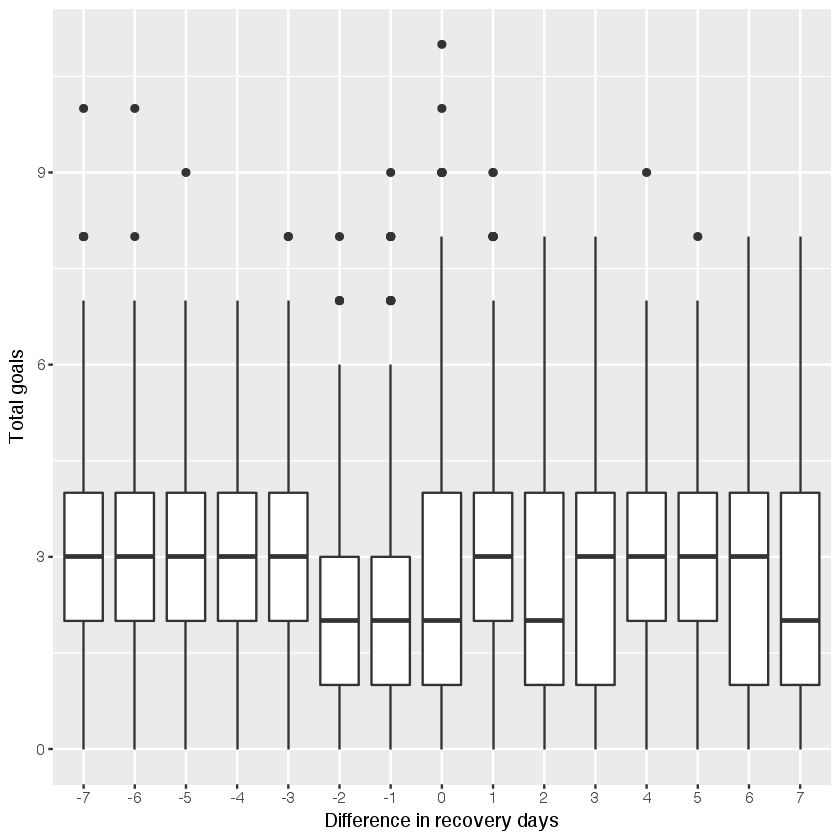

In [259]:
# Now plot recovery time 
ggplot(data = tier_1_games %>% 
       filter(Season > 1992) %>%
       filter(recov_day_diff < 8 & 
              recov_day_diff > -8)) +
       geom_boxplot(mapping = 
                   aes(x = as.factor(recov_day_diff), 
                       y = totgoal), na.rm = TRUE) + 
       labs(x = "Difference in recovery days", y = "Total goals")

In [271]:
cor(tier_1_games$recov_day_diff, tier_1_games$goaldif, use = 'complete.obs')

[1] 0.008025737